# Investigating EHR data from PIC-SURE

The purpose of this notebook is to help researchers get started with EHR analysis in python using clinical data exported from PIC-SURE. 

### About the data
This example code uses a synthetically generated dataset from Synthea, an open-source patient population simulation. 
The dataset has been formatted to mirror what a data export from PIC-SURE may look like.  
It includes all age groups and is not limited to pediatric patients. 



Jason Walonoski, Mark Kramer, Joseph Nichols, Andre Quina, Chris Moesel, Dylan Hall, Carlton Duffett, Kudakwashe Dube, Thomas Gallagher, Scott McLachlan, Synthea: An approach, method, and software mechanism for generating synthetic patients and the synthetic electronic health care record, Journal of the American Medical Informatics Association, Volume 25, Issue 3, March 2018, Pages 230–238, https://doi.org/10.1093/jamia/ocx079



###  Installing packages
The following code installs and loads packages needed for basic data management and manipulation.

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import zipfile
import io


/Users/smakwana/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
pd.set_option('display.max_colwidth', None)

## Loading the data
The following code downloads the dataset. 


In [17]:
# The data is stored on github:
url = "https://github.com/hms-dbmi/pic-sure-public-datasets/raw/main/synthea_10k_picsure_format.csv.zip"

# Download the ZIP file from GitHub
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Open the ZIP file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # List files in the ZIP
    print("Files in ZIP:", z.namelist())
    
    # Extract and load the CSV file (assuming the first file is the desired CSV)
    with z.open(z.namelist()[0]) as f:
        data = pd.read_csv(f)


Files in ZIP: ['synthea_10k_picsure_format.csv', '__MACOSX/._synthea_10k_picsure_format.csv']


/var/folders/nz/k_g_v4910fd_wthf2ngtf13c0000gq/T/ipykernel_38006/1523992457.py:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f)


## Taking a first look at the dataset
Let's use the `head()` function to take a first look at the dataset. 
You'll see 5 columns:
- PATIENT_NUM: Represents a unique patient identifier
- CONCEPT_PATH: Represents the clinical variable for a given observation (row)
- TVAL_CHAR: The text / character value of the clinical variable, if applicable
- NVAL_NUM: The numerical value of the clinical variable, if applicable
- TIMESTAMP: The date and time associated to a given observation (row)


In [25]:
# The timestamp is in unix format. Convert to datetime
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], unit='s')

data.tail()#

,PATIENT_NUM,CONCEPT_PATH,NVAL_NUM,TVAL_CHAR,TIMESTAMP
3737898,11642,\ACT Procedures CPT\Radiology Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest,NaN,"Radiologic examination, chest",2015-08-27 04:00:00
3737899,11642,\ACT Procedures CPT\Radiology Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest,NaN,Radiologic examination,2015-08-27 04:00:00
3737900,11643,\ACT Procedures CPT\Radiology Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest,NaN,"Radiologic examination, chest",2017-04-23 04:00:00
3737901,11643,\ACT Procedures CPT\Radiology Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest,NaN,Radiologic examination,2017-04-23 04:00:00
3737902,11642,\ACT Procedures CPT\Surgery\Surgical Procedures on the Urinary System\Surgical Procedures on the Kidney,NaN,Renal Transplantation Procedures,2018-03-24 04:00:00


The EHR data represented in this dataset may be very large, making it difficult to explore manually. 

You'll notice that the `CONCEPT_PATH` column consists of a hierarchy that narrows down to a certain clinical variable. 

Let's take a look at the highest level of the `CONCEPT_PATH` to see what kind of data we have. We can consider this to be the `VARIABLE_TYPE`.

In [26]:
# Isolate the variable type using regular expressions, and create a new column for variable type
data['VARIABLE_TYPE'] = data['CONCEPT_PATH'].str.extract(r'\\([^\\]+)\\')
# Count how many observations are associated with each variable type
data['VARIABLE_TYPE'].value_counts()

VARIABLE_TYPE
ACT Lab Test Results    2788447
ACT Medications          748721
ACT Diagnosis ICD-10      96705
ACT Procedures CPT        55808
ACT Demographics          48222
Name: count, dtype: int64

As seen above, this dataset contains the following data types: 
- ACT Lab Test Results (Labs)
- ACT Medications
- ACT Diagnosis ICD-10 (Diagnoses)
- ACT Procedures CPT (Procedures)
- ACT Demographics

This dataset should contain about 10,000 synthetic patient records. Let's verify this by checking the count of unique patient IDs present in the dataset. 

In [27]:
data['PATIENT_NUM'].nunique()

11644

Let's also check what date ranges are represented in our dataset. 

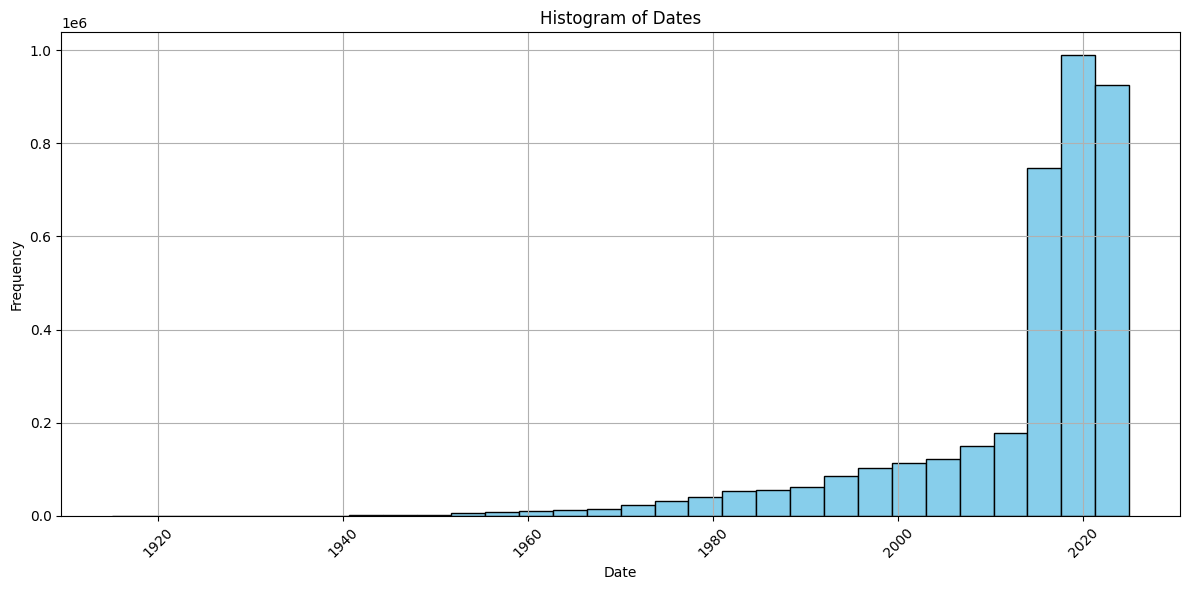

In [28]:
# Changing the time stamp to a date format
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], errors='coerce')
data['DATE'] = data['TIMESTAMP'].dt.date


# Create a histogram of dates
plt.figure(figsize=(12, 6))
data['DATE'].hist(bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Dates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The majority of our dataset is from the last 15 years, as expected. 

We also see data stretching far back to 1920; perhaps this is associated with a patient's age. Depending on your research question, you may want to investigate those outliers. 

## Exploring Demographic Data
Here we will explore, organize and visualize the demographic data available in our dataset. This includes age, sex and race.

Let's create a new dataframe called `demo_df` that will only include the demographics information.

In [29]:
demo_df = data[data['VARIABLE_TYPE'] == 'ACT Demographics']

Let's first take a look at the **sex** breakdown. 

We can find the Sex related observations by searching for this value in the CONCEPT_PATH column. Then, we take the sex related values (found in the TVAL_CHAR column) and transform them into a new column, "sex". 


In [30]:
#isolating and showing sex data:
sex_df = demo_df[demo_df['CONCEPT_PATH'].str.contains(r'\\Sex\\', na=False)]

#creating a new dataset only including the patient id#, sex and changing column name to 'sex':
sex_df = sex_df[['PATIENT_NUM', 'TVAL_CHAR']].rename(columns={'TVAL_CHAR': 'sex'})

sex_df 


#grouping by sex and calculating the percentage of each:
sex_count = (sex_df.groupby('sex')
              .size()
              .reset_index(name='count'))
sex_count['percentage'] = (sex_count['count'] / sex_count['count'].sum()) * 100

sex_count


,sex,count,percentage
0,Female,5747,49.355891
1,Male,5897,50.644109


Now let's look at the **age** distribution of our patients. 

Below, we isolate the age data by searching the CONCEPT_PATH for Age. Then, we take the age related values (found in the NVAL_NUM column) and transform them into a new column, "age". 

In [31]:
# isolating and showing age data:
age_df = demo_df[demo_df['CONCEPT_PATH'].str.contains(r'\\Age\\')]

#creating a new dataset only including the patient id#, age and changing column name to 'age':
age_df = age_df[['PATIENT_NUM', 'NVAL_NUM']].rename(columns={'NVAL_NUM': 'age'})

age_df

,PATIENT_NUM,age
36578,1,5.0
36579,2,15.0
36580,3,8.0
36581,4,60.0
36582,5,9.0
...,...,...
48217,11640,57.0
48218,11641,74.0
48219,11642,65.0
48220,11643,77.0


We can now use this age dataframe to plot the age distribution in our data. 

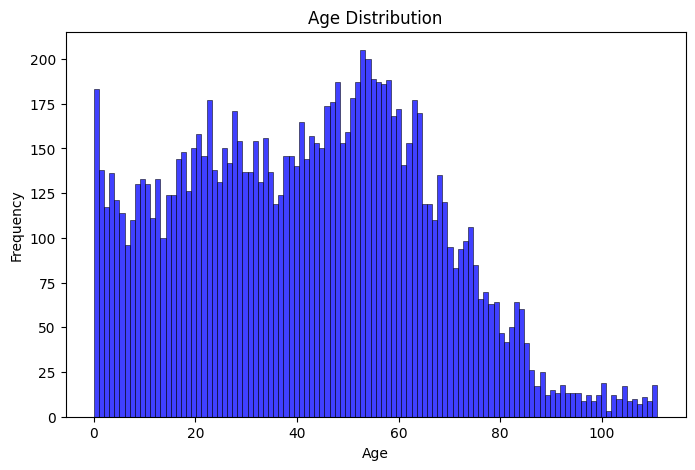

In [32]:
#Creating a histogram demonstrating the age distribution:

plt.figure(figsize=(8, 5))
sns.histplot(age_df['age'], bins=110, color='blue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')


plt.show()

We can also group our patients into age groups and create a table detailing how many patients are in each age group. 

We will group our patients into the following groups: 
- under 18
- 18-65
- 65+

In [33]:
# grouping by age (<18 , 18-65, 65+)

age_group= age_df.copy()

bins = [-float('inf'), 17, 64, float('inf')]
labels = ['<18', '18-65', '65+']

age_group['age_group'] = pd.cut(age_group['age'], bins=bins, labels=labels, right=True)


# Calculate the number of patients in each age group
age_group_sum = age_group['age_group'].value_counts().reindex(labels).reset_index()
age_group_sum.columns = ['age_group', 'count']

age_group_sum

,age_group,count
0,<18,2144
1,18-65,7437
2,65+,2063


Finally, let's investigate the **race** distribution. 

Similarly to above, we isolate the race data by searching the CONCEPT_PATH for Race. Then, we take the race related values (found in the TVAL_CHAR column) and transform them into a new column, "race". 

In [34]:
#isolating and showing race data:
race_data = demo_df[demo_df['CONCEPT_PATH'].str.contains(r'\\Race\\', na=False)]

#creating a new dataset only including the patient id#, age and changing column name to 'age':
race_data = race_data[['PATIENT_NUM', 'TVAL_CHAR']].rename(columns={'TVAL_CHAR': 'race'})


In [35]:
#grouping by race and calculating the percentage of each:

count= race_data['race'].value_counts()
percentages = race_data['race'].value_counts(normalize=True) * 100

race_count= pd.DataFrame({
    'count': count,
    'percentage': percentages, 
    'race' : count.index
    })
race_count

,count,percentage,race
race,,,
White,9648,82.858124,White
Black or African American,918,7.883889,Black or African American
Asian,786,6.750258,Asian
Native Hawaiian or Other Pacific Islander,118,1.013397,Native Hawaiian or Other Pacific Islander
No Information,113,0.970457,No Information
American Indian or Alaska Native,61,0.523875,American Indian or Alaska Native


We will plot these results in a bar plot.

/var/folders/nz/k_g_v4910fd_wthf2ngtf13c0000gq/T/ipykernel_38006/1025067948.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=race_count, x='race', y='percentage', palette='viridis')


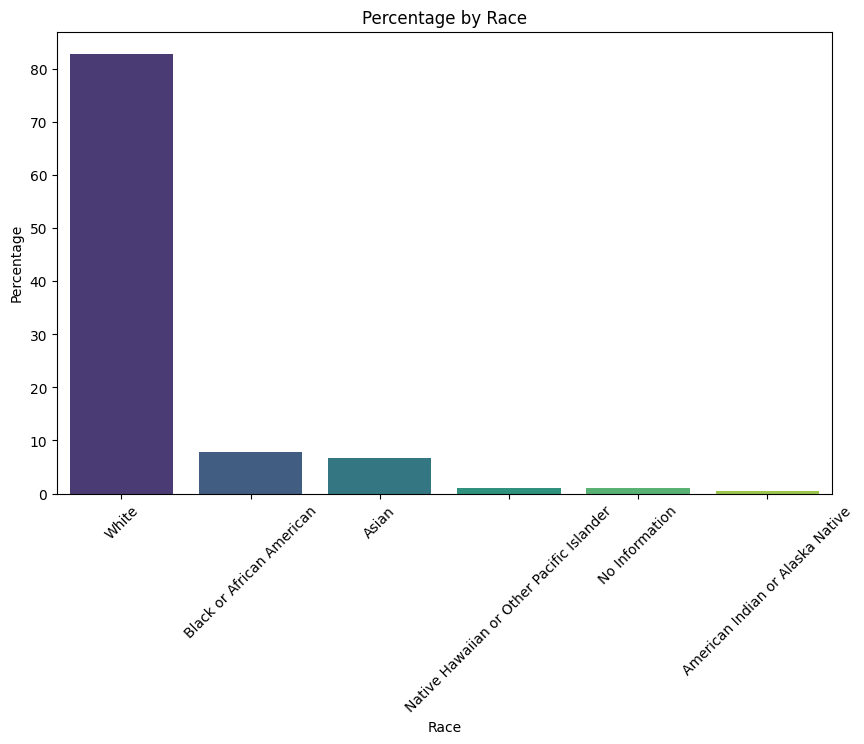

In [36]:
#create a bar plot representing race distribution:
plt.figure(figsize=(10, 6))
sns.barplot(data=race_count, x='race', y='percentage', palette='viridis')
plt.title('Percentage by Race')
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

The way our initial dataset is formatted can be difficult to view multiple variables about a given patient at the same time. 

Below, we create one table presenting all demographic data (age, sex, race) by patient ID. 

In [37]:
#merging all columns to show age, sex, race in one table:

first_merge = pd.merge(age_df[['PATIENT_NUM', 'age']], sex_df[['PATIENT_NUM', 'sex']], on='PATIENT_NUM', how='left')

demographics_joined = pd.merge(first_merge, race_data[['PATIENT_NUM', 'race']], on='PATIENT_NUM', how='left')

demographics_joined

,PATIENT_NUM,age,sex,race
0,1,5.0,Female,White
1,2,15.0,Male,White
2,3,8.0,Male,White
3,4,60.0,Female,White
4,5,9.0,Female,White
...,...,...,...,...
11639,11640,57.0,Male,White
11640,11641,74.0,Female,White
11641,11642,65.0,Female,Black or African American
11642,11643,77.0,Male,White


## Investigating ICD codes: Epilepsy case study

We can isolate the diagnosis related information by searching for 'ACT Diagnosis' in the CONCEPT_PATH column.

In [38]:
#create a new data frame including only the patients diagnosis data:

diagnosis_icd10 = data[data['CONCEPT_PATH'].str.contains(r'\\ACT Diagnosis ICD-10\\')]


### In this case study, we will investigate epilepsy as the disease of interest. 

Epilapsy is represented by  ICD group code "G40", which includes the following and their sub-groups:
- G40.0: Localization-related (focal) (partial) idiopathic epilepsy and epileptic syndromes with seizures of localized onset.
- G40.1: Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with simple partial seizures.
- G40.2: Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures.
- G40.3: Generalized idiopathic epilepsy and epileptic syndromes
- G40.A: Absence epileptic syndrome.
- G40.B: Juvenile myoclonic epilepsy [impulsive petit mal].
- G40.C: Lafora progressive myoclonus epilepsy, intractable.
- G40.4: Other generalized epilepsy and epileptic syndromes.
- G40.5: Epileptic seizures related to external causes.
- G40.8: Other epilepsy and recurrent seizures.
- G40.9: Epilepsy, unspecified.

*A full list of ICD-10 codes can be found at https://www.icd10data.com/ICD10CM/Codes*

### Isolating the patient cohort

First, we create a new data-frame that only includes patients with epilepsy.

We create a variable called `icd_code_of_interest` and set it to `G40`.

(you can replace the ICD code "G40" with the ICD code of your choice if you are interested in investigating a different disease group!):

You can see a preview of this epilepsy focused dataset below.

In [39]:
icd_code_of_interest = 'G40'

#filtering to include only patients diagnosed with epilepsy and recurrent seizures (ICD GROUP CODE G40):

epilepsy_icd10 = diagnosis_icd10[diagnosis_icd10['TVAL_CHAR'].str.contains(icd_code_of_interest)]
epilepsy_icd10 = epilepsy_icd10[['PATIENT_NUM', 'CONCEPT_PATH', 'TVAL_CHAR']].rename(columns={'TVAL_CHAR': 'icd_10_code'})

# creating a final list of patient_ids with epilepsy (G40 group code), removing duplicates entries for same patient id :
epilepsy_icd10_patient_ids = pd.DataFrame(epilepsy_icd10['PATIENT_NUM'].unique(), columns=['PATIENT_NUM'])

epilepsy_icd10.head()

,PATIENT_NUM,CONCEPT_PATH,icd_10_code
48255,9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
48256,9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
48257,9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
48258,9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"
48259,9,"\ACT Diagnosis ICD-10\G00-G99 Diseases of the nervous system (G00-G99)\G40-G47 Episodic and paroxysmal disorders (G40-G47)\G40 Epilepsy and recurrent seizures\G40.9 Epilepsy, unspecified\G40.90 Epilepsy, unspecified, not intractable","G40.909 Epilepsy, unspecified, not intractable, without status epilepticus"


Let's also isolate the demographic data for patients who have been diagnosed with epilepsy, and see how much of our dataset they represent.

In [40]:
# merging the patient id list with the demographic data

epi_demo= pd.merge(epilepsy_icd10_patient_ids, demographics_joined, on='PATIENT_NUM', how='left')

# calculating percentage of patients with epilepsy from total dataset cohort:

epilepsy_percentage = (len(epilepsy_icd10_patient_ids) / data['PATIENT_NUM'].nunique()) * 100           
print(round(epilepsy_percentage, 2), "% of patients in our dataset have been diagnosed with an epilepsy ICD10 code.")  

3.59 % of patients in our dataset have been diagnosed with an epilepsy ICD10 code.


### Investigating the presence of other diagnostic codes in our defined patient cohort
Our cohort consists of patients with epilepsy. 
Let's say we are interested in comparing which patients with epilepsy also have been diagnosed with migranes (ICD GROUP CODE G43).

We create a variable called `icd` and set it to `G43`. (you can replace the ICD code "G43" with the ICD code of your choice in the next chunk of code)

We then search for this ICD code of interest within our cohort. 

In [41]:
icd = 'G43'
# first, creating a dataframe including only patients diagnosed with migraines (ICD GROUP CODE G43)

migraines_icd10 = (diagnosis_icd10[diagnosis_icd10['TVAL_CHAR'].str.contains(icd)]
                  .loc[:, ['PATIENT_NUM', 'CONCEPT_PATH', 'TVAL_CHAR']]
                  .rename(columns={'TVAL_CHAR': 'icd_10_code'}))

#next, extracting only the patient id's and removing any duplicates.
migraines_icd10_patient_ids = pd.DataFrame(migraines_icd10['PATIENT_NUM'].unique(), columns=['PATIENT_NUM'])

#finally, merging the epilepsy patient id list with the migraine patient id list to create a list including only patients that have both epilepsy and migraine ICD10 codes 

epilepsy_migraine= pd.merge(epilepsy_icd10_patient_ids, migraines_icd10_patient_ids, on='PATIENT_NUM', how='inner')



Now, let's examine the original epilepsy dataframe and add a column indicating which patients also have migraines:

In [42]:
# merging the joint list to the original epilepsy patient list, and creating a migraine column indicating if the patient with epilepsy also has a migraine diagnosis (yes=1/ no=0):

epilepsy_migraine['migraines'] = 1

epilepsy_merged = (pd.merge(epilepsy_icd10_patient_ids, epilepsy_migraine, on='PATIENT_NUM', how='left')
                   .fillna({'migraines': 0})
                   .astype({'migraines': int})
                   .merge(epi_demo, on='PATIENT_NUM', how='left')
                   .sort_values(by='PATIENT_NUM'))

epilepsy_merged

,PATIENT_NUM,migraines,age,sex,race
0,9,0,41.0,Male,Black or African American
1,87,0,62.0,Male,White
2,122,0,1.0,Female,Asian
3,149,0,15.0,Male,White
4,175,0,4.0,Male,White
...,...,...,...,...,...
413,11487,0,44.0,Male,White
414,11504,0,68.0,Male,White
415,11527,0,29.0,Female,White
416,11546,0,46.0,Male,White


The following table shows the percentage of patients with migraines in the epilepsy patient cohort.

We can see that only a small percentage of our patients with epilepsy also experience migraines.

In [43]:
#calculating the number and percentage of patient with migraines in the epilepsy patient cohort

epi_mig_count = epilepsy_merged.groupby('migraines').size().reset_index(name='count')
epi_mig_count['percentage'] = round((epi_mig_count['count'] / epi_mig_count['count'].sum()) * 100, 2)

epi_mig_count


,migraines,count,percentage
0,0,398,95.22
1,1,20,4.78


### Investigating what medications have been administered to our cohort of interest

Let's now look into the medications data. We can isolate the medications data by searching the CONCEPT_PATH variable for the term `ACT Medications`.

In [44]:
#creating a new dataframe containing only medication data:

medications = data[data['CONCEPT_PATH'].str.contains(r'\\ACT Medications')]

medications.head()

,PATIENT_NUM,CONCEPT_PATH,NVAL_NUM,TVAL_CHAR,TIMESTAMP,VARIABLE_TYPE,DATE
2933374,3,\ACT Medications\I [Preparations]\Ibuprofen\Ibuprofen Oral Tablet\Ibuprofen 100 Mg Oral Tablet,1.0,NaN,2021-08-10 04:00:00,ACT Medications,2021-08-10
2933375,4,\ACT Medications\D [Preparations]\Diphenhydramine\Diphenhydramine Oral Tablet\Diphenhydramine Hydrochloride 25 Mg Oral Tablet,670.0,NaN,1969-06-07 04:00:00,ACT Medications,1969-06-07
2933376,4,\ACT Medications\C [Preparations]\Clopidogrel\Clopidogrel Oral Tablet\Clopidogrel 75 Mg Oral Tablet,189.0,NaN,2008-12-06 05:00:00,ACT Medications,2008-12-06
2933377,4,\ACT Medications\S [Preparations]\Simvastatin\Simvastatin Oral Tablet\Simvastatin 20 Mg Oral Tablet,189.0,NaN,2008-12-06 05:00:00,ACT Medications,2008-12-06
2933378,4,\ACT Medications\M [Preparations]\Metoprolol\Metoprolol Extended Release Oral Tablet\24 Hr Metoprolol Succinate 100 Mg Extended Release Oral Tablet,189.0,NaN,2008-12-06 05:00:00,ACT Medications,2008-12-06


For our epilepsy case study, we are interested in knowing whether a patient has been administered Carbamazepine or Pregabalin. 
- Carbamazepine is used to manage and treat epilepsy, trigeminal neuralgia, and acute manic and mixed episodes in bipolar I disorder.
- Pregabalin treats nerve and muscle pain, including fibromyalgia. It can also treat seizures.


We will search our dataset for these medications and isolate which patients are associated to those observations.

We then isolate our results to our cohort of interest. 

The resulting table contains information on whether or not a patient who was diagnosed with epilepsy was ever administered carbamazepine or pregabalin. 

In [45]:
#filtering original data set to patients receiving Carbamazepine or/and Pregabalin

carba_preg = (data[data['CONCEPT_PATH'].str.contains(r'Carbamazepine|Pregabalin')]
              [['PATIENT_NUM', 'CONCEPT_PATH']])

#creating a new column indicating if a patient has been prescribed Carbamazepine or Pregabalin (yes=1,no=0) for easier visualization and data manipulation 
carba_preg['carbamazepine'] = carba_preg['CONCEPT_PATH'].str.contains('Carbamazepine').astype(int)
carba_preg['pregabalin'] = carba_preg['CONCEPT_PATH'].str.contains('Pregabalin').astype(int)

carba_preg = carba_preg[['PATIENT_NUM', 'carbamazepine', 'pregabalin']].drop_duplicates()

# merging the patient id list of epilepsy patients with the patient medication data frame, filing missing entries with "0"(=no/ no information included in dataset):

patient_icd10_med = (
    pd.merge(epilepsy_icd10_patient_ids, carba_preg, on='PATIENT_NUM', how='left')
    .fillna(0)
    .astype({'carbamazepine': 'int', 'pregabalin': 'int'})
)


patient_icd10_med.head()

,PATIENT_NUM,carbamazepine,pregabalin
0,9,0,0
1,87,0,0
2,122,0,0
3,149,1,0
4,175,0,0


In [46]:
print(patient_icd10_med['carbamazepine'].value_counts()[1], "patient(s) with epilepsy were taking carbamazepine")
print(patient_icd10_med['pregabalin'].value_counts()[1], "patient(s) with epilepsy were taking pregabalin")

122 patient(s) with epilepsy were taking carbamazepine
1 patient(s) with epilepsy were taking pregabalin


### Invsetigating lab results over time for our cohort of interest

We can isolate the lab related information by searching for 'ACT Lab Test Results' in the CONCEPT_PATH column.

Below is a preview of the labs available in the dataset. 

In [47]:
# Creating a new dataframe containing only the lab test results for all patients in the original dataset:
lab_test_results = data[data['CONCEPT_PATH'].str.contains(r'\\ACT Lab Test Results')]

# creating a list with unique types of lab tests included in the dataset:

lab_list = (lab_test_results[['CONCEPT_PATH']]
                   .drop_duplicates()
                   .sort_values(by='CONCEPT_PATH')
                   .reset_index(drop=True))

lab_list.head()

,CONCEPT_PATH
0,\ACT Lab Test Results\Chemistry\Electrolytes\Bicarbonate\Carbon dioxide in Serum or Plasma
1,\ACT Lab Test Results\Chemistry\Electrolytes\Calcium\Calcium in Blood
2,\ACT Lab Test Results\Chemistry\Electrolytes\Calcium\Calcium in Serum or Plasma
3,\ACT Lab Test Results\Chemistry\Electrolytes\Chloride\Chloride in Blood
4,\ACT Lab Test Results\Chemistry\Electrolytes\Chloride\Chloride in Serum or Plasma


In the following example, we will focus on AST (aspartate aminotransferase) and ALT (alanine transaminase) lab test results. 
We will also only focus on lab results from 2023. 
- AST is an enzyme found in the liver, muscles, and other organs. When cells that contain AST are damaged, they release AST into the blood
- An ALT blood test is used to diagnose liver disorders. ALT is a liver enzyme that is released in the blood when liver cells are damaged.

(you can replace "ALT" or "AST" with your choice of lab test, to add additional lab tests just add a "|" before the next lab test name)


*Note that the number of lab result entries can vary widely per patient, and even multiple entries per day are possible. In the graphic representation and statistical measurement tables, each individual lab result is treated as an individual data point, without the use of weighted averages or other methodological statistical adjustments.*

In [54]:
#filtering the original dataset to include only AST and ALT test results from the year 2023 and cleaning duplicates:
alt_ast = lab_test_results[lab_test_results['CONCEPT_PATH'].str.contains('ALT|AST')]
alt_ast = alt_ast[alt_ast['TIMESTAMP'] >= pd.to_datetime('2023-01-01')]
alt_ast = alt_ast[alt_ast['TIMESTAMP'] <= pd.to_datetime('2023-12-31')]



alt_ast['lab_test'] = np.where(
    alt_ast['CONCEPT_PATH'].str.contains('AST'), 'ast',
    np.where(alt_ast['CONCEPT_PATH'].str.contains('ALT'), 'alt', None)
)


alt_ast = (
    alt_ast
    .rename(columns={'NVAL_NUM': 'value'})
    .loc[:, ['PATIENT_NUM', 'lab_test', 'value', 'TIMESTAMP']]
    .sort_values(by=['PATIENT_NUM', 'TIMESTAMP'])
    .drop_duplicates()
)

alt_ast.head()


,PATIENT_NUM,lab_test,value,TIMESTAMP
145312,11,alt,40.8,2023-07-17 04:00:00
145313,11,ast,35.2,2023-07-17 04:00:00
146748,16,alt,49.6,2023-06-01 04:00:00
146749,16,ast,33.3,2023-06-01 04:00:00
149572,39,alt,52.0,2023-06-26 04:00:00


Let's now graph a distribution of ALT and AST values in 2023.

/var/folders/nz/k_g_v4910fd_wthf2ngtf13c0000gq/T/ipykernel_38006/2280149245.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='lab_test', y='value', data=alt_ast, palette={'ast': 'skyblue', 'alt': 'red'})


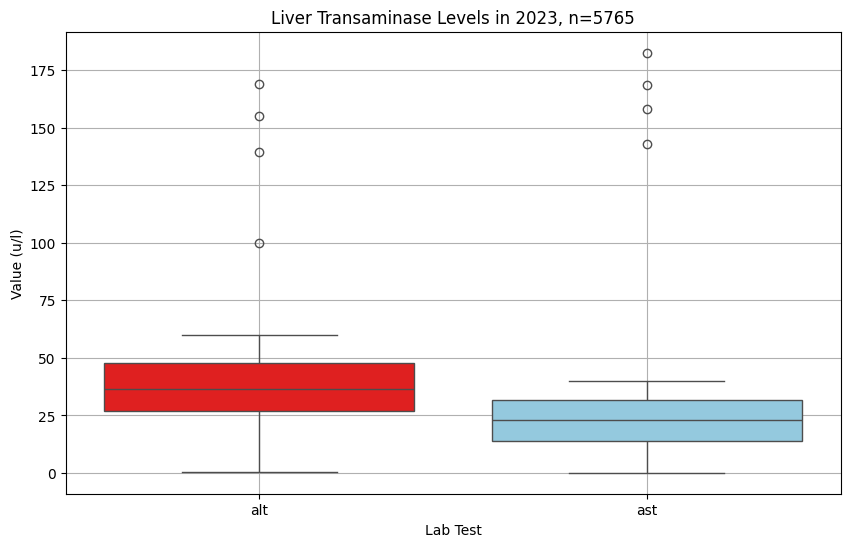

In [55]:
#creating a box plot graph of the results. 


plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='lab_test', y='value', data=alt_ast, palette={'ast': 'skyblue', 'alt': 'red'})
plt.title('Liver Transaminase Levels in 2023, n=' + str(len(alt_ast)))
plt.xlabel('Lab Test')
plt.ylabel('Value (u/l)')
plt.grid(True)
plt.show()



Let's say we are interested in a specific patient with epilepsy. 
Below, we plot the AST and ALT lab trends over the year 2023 for patient id # 1f9e58a1-0b6f-7f53-1495-8b05b69ad4ed.

You can modify this code for any patient of interest by changing the `patient_of_interest` variable.

         PATIENT_NUM lab_test  value           TIMESTAMP
2931499        11641      alt   29.8 2023-01-23 05:00:00
2931500        11641      ast   11.3 2023-01-23 05:00:00
2931549        11641      alt   25.6 2023-02-23 05:00:00
2931550        11641      ast   37.6 2023-02-23 05:00:00
2931615        11641      alt   21.4 2023-03-27 04:00:00
2931616        11641      ast   39.2 2023-03-27 04:00:00
2931644        11641      alt   40.6 2023-04-27 04:00:00
2931645        11641      ast   25.7 2023-04-27 04:00:00
2931686        11641      alt   34.1 2023-05-28 04:00:00
2931687        11641      ast   15.7 2023-05-28 04:00:00
2932099        11641      alt   41.3 2023-10-22 04:00:00
2932100        11641      ast   33.9 2023-10-22 04:00:00


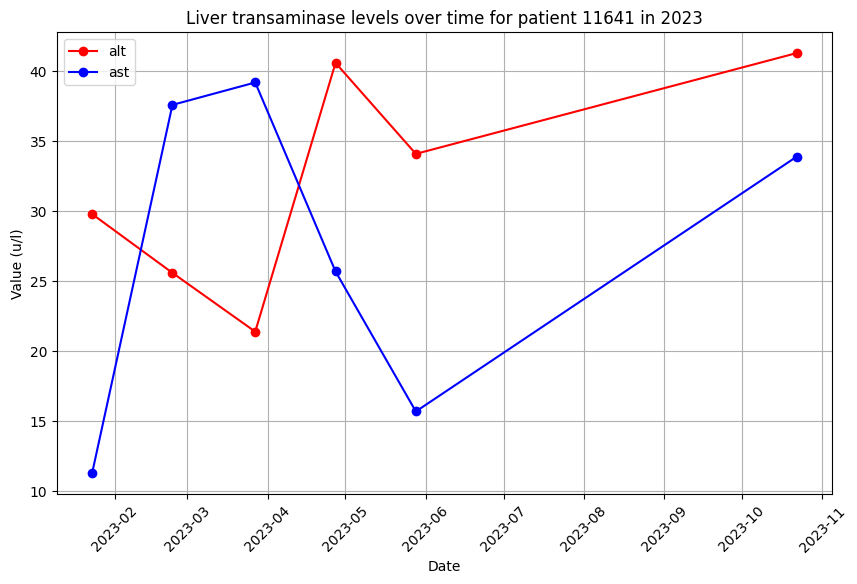

In [69]:
patient_of_interest = 11641

#filtering for the specific patient's AST and ALT levels over time using the 2023 alt/ast dataframe we previously created:
single_patient_data = alt_ast[alt_ast['PATIENT_NUM'] == patient_of_interest]
print(single_patient_data)

# Pivot the data so that each lab test becomes a separate column
patient_data_pivot = single_patient_data.pivot(index='TIMESTAMP', columns='lab_test', values='value')

#creaing a plot showing the results over time:
plt.figure(figsize=(10, 6))
plt.plot(patient_data_pivot.index, patient_data_pivot['alt'], marker='o', linestyle='-', color='r', label='alt')
plt.plot(patient_data_pivot.index, patient_data_pivot['ast'], marker='o', linestyle='-', color='b', label='ast')
plt.title('Liver transaminase levels over time for patient ' +  str(patient_of_interest) + ' in 2023')
plt.xlabel('Date')
plt.ylabel('Value (u/l)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


## Investigating procedural data over time. Case study: Appendectomy.

Finally, let's take a look at the procedures data. 

The procedures are defined by CPT codes. 
We will explore the procedures in this data set and look at specific procedures of interest in a given time frame.

We can isolate the procedure related information by searching for 'ACT Procedures' in the CONCEPT_PATH column.

Below is an example of the procedures documented in this dataset.


In [70]:
# creating a list with unique types of procedures included in the dataset :

procedures = (
    data[data['CONCEPT_PATH'].str.contains(r'\\ACT Procedures')]
    .loc[:, ['CONCEPT_PATH', 'TVAL_CHAR']]
    .drop_duplicates()
    .rename(columns={'TVAL_CHAR': 'procedure'})
)

procedures.head()

,CONCEPT_PATH,procedure
3682095,\ACT Procedures CPT\Radiology Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest,"Radiologic examination, chest"
3682096,\ACT Procedures CPT\Radiology Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures\Diagnostic Radiology (Diagnostic Imaging) Procedures of the Chest,Radiologic examination
3682097,\ACT Procedures CPT\Surgery\Surgical Procedures on the Digestive System\Surgical Procedures on the Colon and Rectum,Endoscopy Procedures on the Rectum
3682104,\ACT Procedures CPT\Surgery\Surgical Procedures on the Integumentary System\Surgical Procedures on the Breast\Excision Procedures on the Breast,Biopsy of breast
3682106,\ACT Procedures CPT\Surgery\Surgical Procedures on the Female Genital System\Surgical Procedures on the Corpus Uteri\Introduction Procedures on the Corpus Uteri,Insertion of intrauterine device (IUD)


Below, we filter the procedural data to identify a cohort of patients who have undergone an appendectomy since the beginning of 2020.

In [74]:
# filtering to create a new dataframe including patients with a history of an appendectomy procedure

appendectomy = (
    data[data['TVAL_CHAR'].str.contains('Appendectomy',na=False)]
    .rename(columns={'TVAL_CHAR': 'procedure'})
    .drop(columns=['CONCEPT_PATH', 'NVAL_NUM'])
    .drop_duplicates()
)

# filtering to only include patients who had an appendectomy since the beginning of the year 2020

appendectomy_2020 = appendectomy[appendectomy['TIMESTAMP'] >= pd.to_datetime('2020-01-01')]

appendectomy_2020.head()

,PATIENT_NUM,procedure,TIMESTAMP,VARIABLE_TYPE,DATE
3683372,251,Appendectomy,2020-11-18 05:00:00,ACT Procedures CPT,2020-11-18
3687591,1210,Appendectomy,2021-11-18 05:00:00,ACT Procedures CPT,2021-11-18
3690114,1743,Appendectomy,2022-11-28 05:00:00,ACT Procedures CPT,2022-11-28
3690148,1759,Appendectomy,2021-08-31 04:00:00,ACT Procedures CPT,2021-08-31
3691958,2192,Appendectomy,2020-10-17 04:00:00,ACT Procedures CPT,2020-10-17
